# **Parameters**

In [1]:
learning_rate=5e-5
datasetType="messidor"
num_workers=2
batch_size=16
IMG_SIZE    = 256

# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import sys
import numpy as np
import pandas as pd
import torchvision
import torch.nn as nn
from tqdm import tqdm, notebook
from PIL import Image, ImageFile
from torch.utils.data import Dataset
from torch import optim, cuda
import torch
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
ImageFile.LOAD_TRUNCATED_IMAGES = True
from timeit import default_timer as timer
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import cv2
import random
from os.path import isfile
import math
import torch.nn.functional as F
import scipy.misc
from skimage.transform import resize
import numpy as np
import gc
import pickle
from sklearn.utils import shuffle

In [3]:
print(torch.cuda.is_available())
if(torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True


# CBAM

In [4]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )
            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw


        scale = torch.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        # print (scale.shape)
        # exit(0)
        return x * scale.to(device)
        

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out) # broadcasting


        return x * scale, scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out, scale = self.SpatialGate(x_out)
        return x_out


# Custom Model

In [5]:
class crossDiseaseAttention(nn.Module):
    def __init__(self):
        super(crossDiseaseAttention, self).__init__()
        self.fc1=nn.Linear(2048,64)
        self.ReLu=nn.ReLU()
        self.fc2=nn.Linear(64,2048)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        G=x
        x=self.fc1(x)
        x=self.ReLu(x)
        x=self.fc2(x)
        xAttention=self.sigmoid(x)
        xAttention=G*xAttention
        return G,xAttention

class CAnetResNext(nn.Module) :

    def __init__(self,baseModel):
        super(CAnetResNext, self).__init__()
        self.features = nn.ModuleList(baseModel.children())[:-2]
        self.pretrained=nn.Sequential(*self.features)
        self.dropOut=nn.Dropout(0.3)
        self.diseaseSpecific_1=CBAM(2048)
        self.diseaseSpecific_2=CBAM(2048)
        self.avgPool=nn.AdaptiveAvgPool2d((1,1))
        self.DiseaseDependent1=crossDiseaseAttention()
        self.DiseaseDependent2=crossDiseaseAttention()
        self.classifiedDR_1=nn.Linear(in_features= 2048,out_features=1,bias=True)
        self.classifiedDME_1=nn.Linear(in_features= 2048,out_features=1,bias=True)
        self.classifiedDR_2=nn.Linear(in_features= 2048,out_features=1,bias=True)
        self.classifiedDME_2=nn.Linear(in_features= 2048,out_features=1,bias=True)


    def forward(self,x):
        x=self.pretrained(x)
        x=self.dropOut(x)
        x1=self.diseaseSpecific_1(x)
        x2=self.diseaseSpecific_2(x)
        x1=self.avgPool(x1)
        gap=x1
        x2=self.avgPool(x2)
        x1=x1.view(x1.size(0), -1)
        x2=x2.view(x2.size(0), -1)
        g1,g1_attention=self.DiseaseDependent1(x1)
        g2,g2_attention=self.DiseaseDependent1(x2)
        out1=self.classifiedDR_1(g1)
        out2=self.classifiedDME_1(g2)
        g1=self.classifiedDR_2(g1+g2_attention)
        g2=self.classifiedDME_2(g2+g1_attention)
        return g1,g2,out1,out2,gap


# Helper Function

In [6]:
def count_parameters(model):
    return (sum(p.numel() for p in model.parameters() if p.requires_grad)/10e6, " Millions !!")
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(image, sigmaX=10 ):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']


def train(model,learningRate,dataLoader,cvLoader,n_epochs=2,dme=True):
        dme=(datasetType=="messidor")
        lambda_value=0.25
        criterion=nn.MSELoss()
        optimizer=optim.Adam(model.parameters(),lr=learningRate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        save_file_name='resnetx101.pt'
        max_epochs_stop=5
        print_every=1
        #model.epochs=0
        ct=0
        for child in model.children():
            if ct < 2:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                for param in child.parameters():
                    param.requires_grad = True
            ct=ct+1
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learningRate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.95)
        epochs_no_improve = 0
        valid_loss_min = np.Inf
        valid_max_acc = 0
        history = []
        try:
            print(f'Model has been trained for: {model.epochs} epochs.\n')
        except:
            model.epochs = 0
            print(f'Starting Training from Scratch.\n')
        overall_start = timer()
        for epoch in (range(n_epochs)):
            # keep track of training and validation loss each epoch
            if(epoch==0):
                for param in model.parameters():
                        param.requires_grad = True 
                optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learningRate,weight_decay=1e-5)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.95)
            train_loss = 0.0
            valid_loss = 0.0

            train_mse = 0
            valid_mse = 0

            # Set to training
            model.train()
            start = timer()

            # Training loop
            for ii, (data, target) in enumerate((dataLoader)):
                if(dme):
                    target=[item.to(device).unsqueeze(1) for item in target]
                else:
                    target=target.to(device).unsqueeze(1)
                data=data.to(device)
                #target=target.unsqueeze(1)
                # Clear gradients
                optimizer.zero_grad()
                # Predicted outputs are log probabilities
                output = model(data)
                # Loss and backpropagation of gradients
                loss=0
                if (dme):
                    loss1= criterion(output[0], target[0])
                    loss2=criterion(output[1],target[1])
                    loss3=criterion(output[2],target[1])
                    loss4=criterion(output[3],target[0])
                    loss=loss1+loss2+lambda_value*(loss3+loss4)
                else:
                    loss=criterion(output[0],(target.float()))
                loss.backward()

                # Update the parameters
                optimizer.step()
                # Track train loss by multiplying average loss by number of examples in batch
                train_loss += loss.item() 
                # Calculate accuracy by finding max log probability
                #_, pred = torch.max(output, dim=1)
                #correct_tensor = pred.eq(target.data.view_as(pred))
                # Need to convert correct tensor from int to float to average
                #accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples in batch
                #train_acc += accuracy.item() * data.size(0)

                # Track training progress
                print(
                    f'Epoch: {epoch}\t{100 * (ii + 1) / len(dataLoader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                    end='\r')
            model.epochs += 1
            # After training loops ends, start validation
            if(epoch%5==0):
                    # Don't need to keep track of gradients
                with torch.no_grad():
                    # Set to evaluation mode
                    model.eval()

                    # Validation loop
                    for data, target in cvLoader:
                        # Tensors to gpu
                        if(dme):
                            target=[item.to(device).unsqueeze(1) for item in target]
                        else:
                            target=target.to(device).unsqueeze(1)
                        data = data.to(device)
                        # Forward pass
                        output = model(data)

                        # Validation loss
                        if (dme):
                            loss1= criterion(output[0], target[0])
                            loss2=criterion(output[1],target[1])
                            loss3=criterion(output[2],target[1])
                            loss4=criterion(output[3],target[0])
                            loss=loss1+loss2+lambda_value*(loss3+loss4)
                        else:
                            loss=criterion(output[0],target)
                        # Multiply average loss times the number of examples in batch
                        valid_loss += loss.item()
                        # Calculate validation accuracy
                        #_, pred = torch.max(output, dim=1)
                        #correct_tensor = pred.eq(target.data.view_as(pred))
                        #accuracy = torch.mean(
                            #correct_tensor.type(torch.FloatTensor))
                        # Multiply average accuracy times the number of examples
                        #valid_acc += accuracy.item() * data.size(0)

                    # Calculate average losses
                    train_loss = train_loss / len(dataLoader)
                    valid_loss = valid_loss / len(cvLoader)

                    # Calculate average accuracy
                    #train_acc = train_acc / len(train_loader.dataset)
                    #valid_acc = valid_acc / len(valid_loader.dataset)

                    history.append([train_loss, valid_loss,scheduler.get_lr()[0],model.epochs])

                    # Print training and validation results
                    if (epoch + 1) % print_every == 0:
                        print(
                            f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                        )
                        print('lr:', scheduler.get_lr()[0])
                        #print(
                        #    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                        #)

                    # Save the model if validation loss decreases
                    if valid_loss < valid_loss_min:
                        # Save model
                        torch.save(model.state_dict(), save_file_name)
                        torch.save(model,"CANet-250epochv16")
                        # Track improvement
                        epochs_no_improve = 0
                        valid_loss_min = valid_loss
                        best_epoch = epoch

                    # Otherwise increment count of epochs with no improvement
                    else:
                        epochs_no_improve += 1
                        # Trigger early stopping
                        if epochs_no_improve >= max_epochs_stop:
                            print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
                            total_time = timer() - overall_start
                            print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                            # Load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # Attach the optimizer
                            model.optimizer = optimizer

                            # Format history
                            history = pd.DataFrame(history,columns=['train_loss', 'valid_loss','Learning_rate','epochs'])
                            return model,history
            scheduler.step()
        # Attach the optimizer
        model.optimizer = optimizer
        # Record overall time and print out stats
        total_time = timer() - overall_start
        print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} ')
        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')
        # Format history
        history = pd.DataFrame(history,columns=['train_loss', 'valid_loss','Learning_rate','epochs'])
        return model,history
def plotLoss(history):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(history['epochs'],history[c],label=c)
        plt.legend()
        plt.xlabel('no of epochs')
        plt.ylabel('MSE Losses')
        plt.title('Training and Validation Losses')
def saveHistory(fileName,history):
    history.to_pickle(fileName)
def retriveHistory(fileName):
    history=pd.read_pickle(fileName)
    return history
def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()
   

# DataSet And Data Loader

In [7]:
def expand_path(p):
    train_2015=""
    testPath=""
    trainPath="../input/aptos2019-blindness-detection/train_images/"
    messidorPath="../input/messidor2/IMAGES/"
    p = str(p)
    if isfile(trainPath + p + ".png"):
        return trainPath + (p + ".png")
    if isfile(testPath + p + ".png"):
        return testPath + (p + ".png")
    if isfile(messidorPath + p ):
        return (messidorPath + p)
    if isfile(messidorPath + p[:-3]+'JPG' ):
        return (messidorPath + p[:-3]+'JPG' )
    return False
normalize = transforms.Normalize([0.55387044 ,0.5336158 , 0.5232084 ], [0.2063595 , 0.18827829, 0.15147245])
traintransforms = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                # transforms.RandomRotation(90),
                # transforms.ColorJitter(0.05, 0.05, 0.05, 0.05),
                transforms.ToTensor(),
                normalize,
                ])
camtransforms = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                ])
camtransforms_normalized = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                normalize,
                ])
class RetinopathyDatasetTest(Dataset):
    def __init__(self, data, transform, dtype="messsidor",mode='train'):
        self.data = data
        self.transform = transform
        self.dtype=dtype
        self.mode=mode
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #directory='../input/aptos2019-blindness-detection/'+self.dtype+'_images'
        #img_name = os.path.join(directory, self.data.loc[idx, 'id_code'] + '.png')
        #print(idx)
        if(self.dtype=="messidor"):
            img_name=expand_path(self.data.loc[idx, 'image_id'])
        else:
            img_name=expand_path(self.data.loc[idx, 'id_code'])
        #print(img_name)
        #image = cv2.imread(img_name)
        #image = load_ben_color(image, sigmaX=10 )
        #image = Image.fromarray(image)
        image=Image.open(img_name)
        image=image.convert("RGB")
        if(self.mode=="cam"):
            image1=camtransforms_normalized(image)
            image2=camtransforms(image)
        else:
            image = self.transform(image)
        if(self.dtype=='messidor'):
            label=[0,0]
            label[0]=self.data['adjudicated_dr_grade'][idx]
            label[1]=self.data['adjudicated_dme'][idx]
        else:
            label=self.data['diagnosis'][idx]
        if(self.mode=='test'):
            return {'image': image}
        elif(self.mode=='train'):
            return image,label
        elif(self.mode=="cam"):
            return image1,image2,label

messidorDf=pd.read_csv("../input/messidor2-dr-grades/messidor_data.csv")
messidorDf=messidorDf[messidorDf['adjudicated_gradable']==1]
messidorDf=messidorDf.reset_index(drop=True)
trainDf=messidorDf


In [8]:

def plotDistribution(trainDf,disease):
    f, ax = plt.subplots(figsize=(14, 8.7))
    ax = sns.countplot(x=disease, data=trainDf, palette="GnBu_d")
    sns.despine()
    plt.show()


messidorDf=pd.read_csv("../input/messidor2-dr-grades/messidor_data.csv")
messidorDf=messidorDf[messidorDf['adjudicated_gradable']==1] 
messidorDf.head()

messidorDf["adjudicated_dme"].value_counts()

corr=pd.crosstab(messidorDf["adjudicated_dr_grade"],messidorDf["adjudicated_dme"])
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(corr,annot = True,cmap=cmap)

corr

In [9]:
if(datasetType=="messidor"):
    disease='adjudicated_dr_grade'
else:
    disease="diagnosis"
def preapreData(datasetType):
    if(datasetType=="messidor"):
        messidorDf=pd.read_csv("../input/messidor2-dr-grades/messidor_data.csv") 
        messidorDf=messidorDf[messidorDf['adjudicated_gradable']==1] 
        trainDf=messidorDf.reset_index(drop=True)
    else:

        trainDf=pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
    plotDistribution(trainDf,disease)
    counts=trainDf[disease].value_counts()
    traindf_4 = trainDf[trainDf[disease] == 4]
    traindf_0 = trainDf[trainDf[disease] == 0]
    traindf_1 = trainDf[trainDf[disease] == 1]
    traindf_1 = traindf_1.sample(counts[0],replace=True)
    traindf_2 = trainDf[trainDf[disease] == 2]
    traindf_2 = traindf_2.sample(counts[0],replace=True)
    traindf_3 = trainDf[trainDf[disease] == 3]
    traindf_3 = traindf_3.sample(counts[0],replace=True)
    traindf_4 = trainDf[trainDf[disease] == 4]
    traindf_4 = traindf_4.sample(counts[0],replace=True)
    df=traindf_0
    df=df.append(traindf_1)
    df=df.append(traindf_2)
    df=df.append(traindf_3)
    df=df.append(traindf_4)
    df=shuffle(df)
    trainDf=df.reset_index(drop=True)
    plotDistribution(trainDf,disease)
    return trainDf


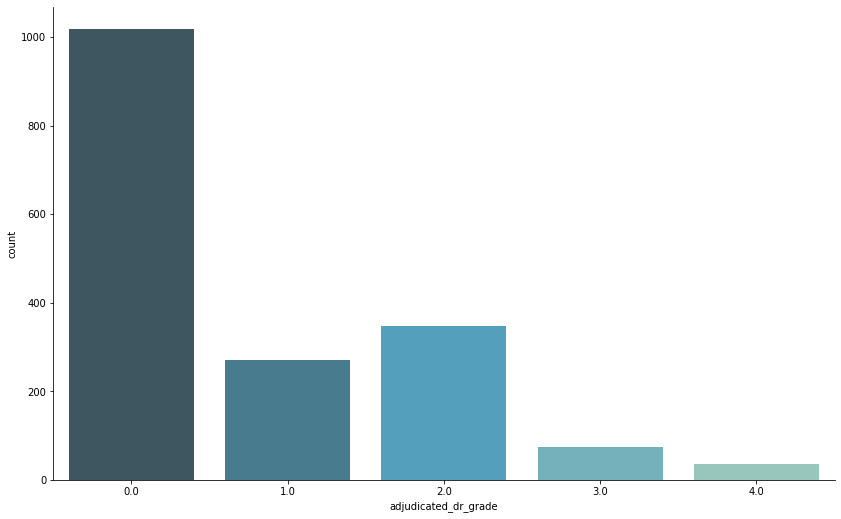

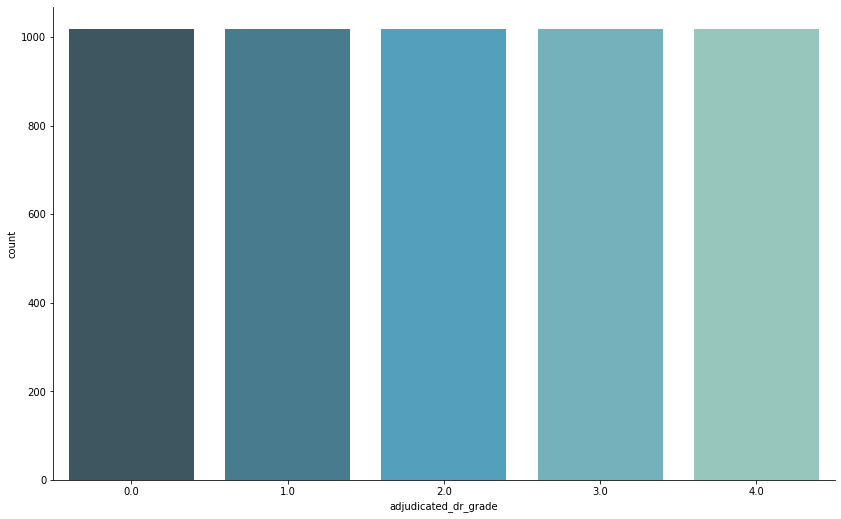

In [10]:
trainDf=preapreData(datasetType)

In [11]:
traindf,cvdf=train_test_split(trainDf, test_size=0.25, random_state=2019, stratify=trainDf[disease])
traindf=traindf.reset_index(drop=True)
cvdf=cvdf.reset_index(drop=True)
#trainSampler=torch.utils.data.RandomSampler(trainDf.index,replacement=True,num_samples=int(len(trainDf)/5))
#cvSampler=torch.utils.data.RandomSampler(trainDf.index,replacement=True,num_samples=int(len(trainDf)/25))

train_dataset = RetinopathyDatasetTest(data=traindf,transform=traintransforms,dtype=datasetType,mode='train')
cv_dataset = RetinopathyDatasetTest(data=cvdf,
                                      transform=traintransforms,dtype=datasetType,mode='train')
trainLoader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
cvLoader=torch.utils.data.DataLoader(cv_dataset, batch_size=batch_size, num_workers=num_workers)



In [12]:
!wget "https://www.kaggleusercontent.com/kf/34264724/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..jbQUHZcfFRYWb2HgFyol-Q.FBfWw2xFo8Bt6a0lRKDmoeaUiu3Qk3OYHqc9t1WRpn5yKUg11Eec6bmjCPKrxILw3c8NAWhFjsJyBUQqNhl6dLykpS77IOu09iWFH42t0DgWzjxgCkAu_y_gnI06wH28ATpw895z8n4RaVJckgQlZL8R1mRqBxxqJtnLeT1r055DDv6_HY_7x3wh1JaaMu0WC3IdVnnAJ3DXDVblYxjqArjksir1KPwn85yOweDoipIcYWSfExa-_qA2DaiyrrKptiJadwWgbXFsBE0Wf9cGcqFeKWQtYEVT-fc2wNzflfc8NOuJ8IXPq8gIz5GdW3IcsiJLAeZEptiiXeb2FJcF6GfzKg4uX1GUqlz0Zafrw4-o8PzgTaWhsolnSTLIFMIqUew4dlTEq_i2IJ9xrwA1qMyoqd0ZaOZno1CrERidcyoonPigHIHzIuB1S2qoVvCj4Nam3_Ud4Jck43tPTI09QpY5CBOptY8nPGk--pL2xLWx6PBI-vovqDrTHDyFO7fa8lkgPwLvydoeDhuTDsWs3dpssEGhRqrpITGZo1KGrgkTdNx3-gnv2GRJ9R26daFJvdpAmW3JItYOA4Zgvvn--WeEKmpexLJHc70XTJDGkDpBSeSyksEaXUgkzQeGDZRow_wQ7JwyY86UvOwR9ohvVunlkAIkjO2R2V0shfOkvZ8.Jc19q5hQKF_crc4b2p5TQA/CANet-250epochv16"

--2020-05-24 04:16:14--  https://www.kaggleusercontent.com/kf/34264724/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..jbQUHZcfFRYWb2HgFyol-Q.FBfWw2xFo8Bt6a0lRKDmoeaUiu3Qk3OYHqc9t1WRpn5yKUg11Eec6bmjCPKrxILw3c8NAWhFjsJyBUQqNhl6dLykpS77IOu09iWFH42t0DgWzjxgCkAu_y_gnI06wH28ATpw895z8n4RaVJckgQlZL8R1mRqBxxqJtnLeT1r055DDv6_HY_7x3wh1JaaMu0WC3IdVnnAJ3DXDVblYxjqArjksir1KPwn85yOweDoipIcYWSfExa-_qA2DaiyrrKptiJadwWgbXFsBE0Wf9cGcqFeKWQtYEVT-fc2wNzflfc8NOuJ8IXPq8gIz5GdW3IcsiJLAeZEptiiXeb2FJcF6GfzKg4uX1GUqlz0Zafrw4-o8PzgTaWhsolnSTLIFMIqUew4dlTEq_i2IJ9xrwA1qMyoqd0ZaOZno1CrERidcyoonPigHIHzIuB1S2qoVvCj4Nam3_Ud4Jck43tPTI09QpY5CBOptY8nPGk--pL2xLWx6PBI-vovqDrTHDyFO7fa8lkgPwLvydoeDhuTDsWs3dpssEGhRqrpITGZo1KGrgkTdNx3-gnv2GRJ9R26daFJvdpAmW3JItYOA4Zgvvn--WeEKmpexLJHc70XTJDGkDpBSeSyksEaXUgkzQeGDZRow_wQ7JwyY86UvOwR9ohvVunlkAIkjO2R2V0shfOkvZ8.Jc19q5hQKF_crc4b2p5TQA/CANet-250epochv16
Resolving www.kaggleusercontent.com (www.kaggleusercontent.com)... 35.190.26.106
Connecting to www.kaggleusercontent.com (www.kaggle

In [13]:
canet="CANet-250epochv16"
model=torch.load(canet,map_location=device)
torch.save(model,canet)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CAnetResNext. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CBAM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ChannelGate. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3

In [14]:
print(model.epochs)

392


In [15]:
#model,history=train(model,learning_rate,trainLoader,cvLoader,n_epochs=15,dme=False)

plotLoss(history)
saveHistory("history.pickle",history)
history2=retriveHistory('history.pickle')
plotLoss(history)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

def Run_validation(cv_loader,model):
    valid_preds = []
    labels=[]
    tk0 = tqdm(cv_loader)
    for ii, (x_batch,label) in enumerate(tk0):
         with torch.no_grad():
            #x_batch = x_batch["image"]
            #print(label)
            pred = model(x_batch.to(device))
            pred=pred[0]
            if(datasetType=="messidor"):
                label=label[0]
            #print(pred.shape)
            valid_preds.append(pred.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1))
            labels.append(label)
    predict_valid=valid_preds[0]
    for i in range(1,len(cv_loader)):
        predict_valid=np.append(predict_valid,valid_preds[i])
    label_valid=labels[0].numpy()
    for i in range(1,len(cv_loader)):
        label_valid=np.append(label_valid,labels[i].numpy())
    return predict_valid,label_valid
def confusionMatrics(preds_valid,label_valid):
    labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
    cnf_matrix = confusion_matrix(label_valid, preds_valid)
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(16, 7))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()



optR = OptimizedRounder()
predict_valid,label_valid=Run_validation(cvLoader,model)

optR.fit(predict_valid,label_valid)
coefficients=optR.coefficients()
print(coefficients)
preds_valid=optR.predict(predict_valid,coefficients)
confusionMatrics(preds_valid,label_valid)

print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(preds_valid, label_valid, weights='quadratic'))

predict_valid_1,label_valid_1=Run_validation(cvLoader,model)
preds_valid_1=optR.predict(predict_valid_1,coefficients)
confusionMatrics(preds_valid_1,label_valid_1)


print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(preds_valid_1, label_valid_1, weights='quadratic'))

coefficients_1=[0.5, 1.5, 2.5, 3.5]
preds_valid_2=optR.predict(predict_valid_1,coefficients_1)
confusionMatrics(preds_valid_2,label_valid_1)

print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(preds_valid_2, label_valid_1, weights='quadratic'))

count_parameters( model)

history

# Score-CAM

In [16]:
import torch
import torch.nn.functional as F
class ScoreCAM():
    def __init__(self, model):
        
        def forward_hook(module, input, output):
            self.activations= output.to(device)
            return None
        self.model=model
        self.activations = None
        self.model.features[7][2].relu.register_forward_hook(forward_hook)

    def forward(self, input):
        b, c, h, w = input.size()
        
        # predication on raw input
        baseScore = self.model(input)
        activations = self.activations.to(device)
        b, k, u, v = activations.size()
        finalAcivationMap = torch.zeros((b, 1, h, w)).to(device)
        contributionStack=torch.zeros(b,k,1).to(device)
        activationMapStack=torch.zeros((b, k,1, h, w)).to(device)
        with torch.no_grad():
            for i in tqdm(range(k)):

                # upsampling
                #activationMap = torch.unsqueeze(activations[:, i, :, :], 1)
                #saliency_map=activationMap
                activationMap=activations[:, i, :, :]
                activationMap = torch.unsqueeze(activationMap, 1)
                activationMap = F.interpolate(activationMap, size=(h, w), mode='bilinear', align_corners=False)
                activationMapStack[:,i]=activationMap
                if activationMap.max() == activationMap.min():
                    continue
              
              # normalize to 0-1
                norm_saliency_map = (activationMap - activationMap.min()) / (activationMap.max() - activationMap.min())

                # how much increase if keeping the highlighted region
                # predication on masked input
                score = self.model(input * norm_saliency_map)
                contributionStack[:,i]=score[0]-baseScore[0]
                #score_saliency_map +=  contribution * saliency_map
        contributionStack= F.softmax(contributionStack) 
        contributionStack=torch.squeeze(contributionStack,2)
        activationMapStack=torch.squeeze(activationMapStack,2)
        for j in tqdm(range(b)):
            for i in range (k):
                finalAcivationMap[j] +=  contributionStack[j,i] * activationMapStack[j,i]
        #finalAcivationMap = F.relu(finalAcivationMap)
        finalAcivationMapMin, finalAcivationMapMax = finalAcivationMap.min(), finalAcivationMap.max()

#         if finalAcivationMapMin == finalAcivationMapMax:
#             return None

#         finalAcivationMap = (finalAcivationMap - finalAcivationMapMin).div(finalAcivationMapMax - finalAcivationMapMin).data

        return finalAcivationMap

    def __call__(self, input):
        return self.forward(input)

In [17]:
def generateBatch(traindf):
    colNames=traindf.columns
    batchDf=pd.DataFrame(columns = colNames)
    for i in range(5):
        row=traindf[traindf[disease]==i].sample()
        batchDf=batchDf.append(row)
    batchDf=batchDf.reset_index(drop=True)
    return batchDf
        
    

In [18]:
batchDf=generateBatch(traindf)

In [19]:
cam_dataset=RetinopathyDatasetTest(data=traindf,transform=camtransforms_normalized,dtype=datasetType,mode='cam')
cam_loader=torch.utils.data.DataLoader(cam_dataset, batch_size=5, num_workers=1)

In [20]:
image_normalized,image,label=next(iter(cam_loader))
image,image_normalized=image.to(device),image_normalized.to(device)
score_cam=ScoreCAM(model)
activationMap=score_cam(image_normalized)

100%|██████████| 2048/2048 [02:15<00:00, 15.15it/s]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


In [21]:
def plotScorecam(image,image_normalized,cam_image):
    fig, axes = plt.subplots(5, 1,figsize=(15,15))
    plt.axis('off')
    cam_image=torch.squeeze(cam_image,1)
    for row in range(5):
        axes[row].text(0.5, 1.2,"Images And Attention Map of DR level "+str(row))
        axes[row].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        axes[row].frameon = False
    cam_image=torch.squeeze(cam_image,1)
    for i in range(5):
        ax1=fig.add_subplot(5,4,(i*4)+1)
        ax1.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax1.imshow(np.transpose(image[i].cpu(), (1, 2, 0)))
        ax2=fig.add_subplot(5,4,(i*4)+2)
        ax2.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax2.imshow(np.transpose(image_normalized[i].cpu(), (1, 2, 0)))
        ax3=fig.add_subplot(5,4,(i*4)+3)
        ax3.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax3.imshow((cam_image[i].cpu()))
        ax4=fig.add_subplot(5,4,(i*4)+4)
        ax4.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax4.imshow(np.transpose(image[i].cpu(), (1, 2, 0)))
        ax4.imshow((cam_image[i].cpu()),alpha=0.4)
        if(i==0):
            ax1.set_title("Original Image")
            ax2.set_title("Normalized Image")
            ax3.set_title("Attention Map")
            ax4.set_title("Super imposed Image")
    plt.tight_layout()
    plt.show()

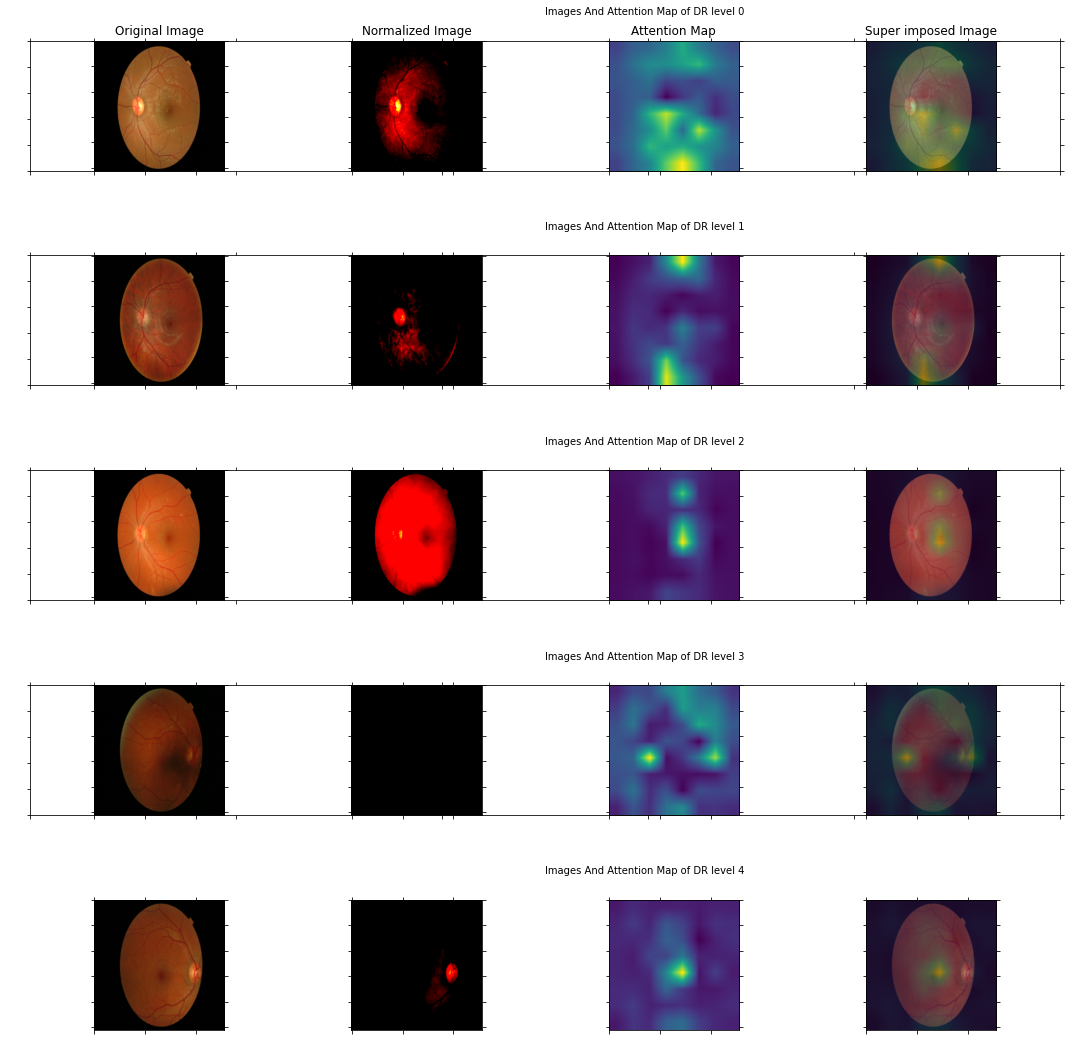

In [22]:
plotScorecam(image,image_normalized,activationMap)

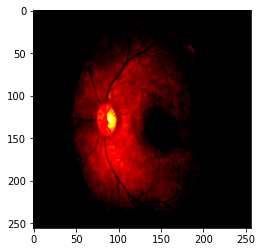

In [23]:
plt.imshow(np.transpose(image_normalized[0].cpu(), (1, 2, 0)))